# Welkom bij Tutorial 4

Dit is alweer de laatste tutorial van Algoritmiek en Datastructuren, waarin wij **grafen** gaan bestuderen. Een graaf is een datastructuur waarin nodes (die in de context van grafen ook wel **vertices** heten) aan elkaar verbonden zijn door middel van **edges**. 

De manier waarop er meestal over grafen geschreven wordt is al een tuple $G = (V, E)$ waarbij G de graaf is, V de *set* van nodes/vertices en E de *set* van edges. Ik schrijf hier *set* schuingedrukt, omdat dit een bekende datastructuur voor ons is: een container waarin geen dubbelen mogen zitten. 

Vertices zijn uiteraard een classes die data kunnen bevatten, maar ook de edges kunnen soms data bevatten. Bijvoorbeeld, in een shortest path problem (zie Reader) stellen de vertices/nodes locaties voor, en bevatten dus de naam van de locatie, en de edges verbindingen tussen deze locaties. De edges bevatten de *afstand* (bijvoorbeeld in kilometers) tussen deze locaties. 

Grafen zijn een zeer flexibele manier van data structuren: zolang er maar verbindingen tussen nodes en edges gelegd kunnen worden is het een valide implementatie van een graaf. Dit kan je natuurlijk op heel veel verschillende manieren doen. Laten we daar eens een paar van gaan bekijken. 

We gaan dit graafje maken: https://en.wikipedia.org/wiki/File:Dijkstra_Animation.gif 

In [32]:
from matplotlib import pyplot as plt
import numpy as np
import time
import statistics as stats
import math

In [33]:
# Een zeer generieke manier om een graaf de implementeren is er 
# daarwerkelijk twee sets van te maken op basis van twee classes: 
class Vertex: 
    def __init__(self, identifier, data_):
        self.id = identifier
        self.data = data_
        
    def __eq__(self, other): #nodig om aan een set toe te voegen
        return self.id == other.id
    
    def __hash__(self): #nodig om aan een set toe te voegen
        return hash(self.id)
    
    def __repr__(self):
        return str(self.id)+":"+str(self.data)
        
class Edge:
    def __init__(self, vertex1, vertex2, data_):
        if(vertex1.id<vertex2.id):
            self.v1 = vertex1
            self.v2 = vertex2
        else:
            self.v1 = vertex2
            self.v2 = vertex1
        self.data = data_
        
    def __eq__(self, other): #nodig om aan een set toe te voegen
        return self.v1.id == other.v1.id and self.v2.id == self.v2.id
    
    def __hash__(self): #nodig om aan een set toe te voegen
        return hash(str(self.v1.id)+","+str(self.v2.id))
    
    def __repr__(self):
        return "("+str(self.v1.id)+","+str(self.v2.id)+"):"+str(self.data)

class CGraph:
    def __init__(self):
        self.V = set()
        self.E = set()
        
    def __str__(self):
        return "V: "+str(self.V)+"\nE: "+str(self.E)
            
        
# So, for a simple shortest path problem: 
gr = CGraph()
v1 = Vertex(1,"start")
v2 = Vertex(2,"")
v3 = Vertex(3,"")
v4 = Vertex(4,"")
v5 = Vertex(5,"goal")
v6 = Vertex(6,"")
gr.V.add(v1)
gr.V.add(v2)
gr.V.add(v3)
gr.V.add(v4)
gr.V.add(v5)
gr.V.add(v6)
e1 = Edge(v1,v2,7)
e2 = Edge(v1,v3,9)
e3 = Edge(v1,v6,14)
e4 = Edge(v2,v3,10)
e5 = Edge(v2,v4,15)
e6 = Edge(v3,v4,11)
e7 = Edge(v3,v6,2)
e8 = Edge(v6,v5,9)
e9 = Edge(v4,v5,6)
gr.E.add(e1)
gr.E.add(e2)
gr.E.add(e3)
gr.E.add(e4)
gr.E.add(e5)
gr.E.add(e6)
gr.E.add(e7)
gr.E.add(e8)
gr.E.add(e9)
print(gr)

# Is dit eigenlijk al best een langdradige manier van doen...

V: {1:start, 2:, 3:, 4:, 5:goal, 6:}
E: {(3,4):11, (2,3):10, (4,5):6, (1,2):7, (1,6):14, (2,4):15, (5,6):9, (1,3):9, (3,6):2}


In [34]:
#Daarom kiezen mensen er vaak voor om een graaf makkelijker te respresenteren met standaard datatypes
#bijvoorbeeld: als we een dictionary maken met node identifiers als keys, en een tuple van (data, edges) als values
#met edges als een dictionary met vertex ids van de verbonden vertices als keys en de data van de edge als key
#krijgen we zoiets voor dezelfde graaf
DGraph = dict
gr2 = {1: ("start", {2:7, 3:9, 6:14}),
       2: ("", {1:7, 3:10, 4:15}), 
       3: ("", {1:9, 2:10, 4:11, 6:2}), 
       4: ("", {2:15, 3:11, 5:6}), 
       5: ("goal", {4:6, 6:9}), 
       6: ("", {1:14, 3:2, 5:9})
      }
print(gr2)
#Dat is makkelijker in te voeren... Maar je moet wel goed bijhouden wat ookalweer wat is. 
#Bovendien heb ik er nu wat redundantie ingezet (elke node bevat de edges waaraan het verbonden zit, dus elke 
# edge zit twee maal in deze datastructuur)

{1: ('start', {2: 7, 3: 9, 6: 14}), 2: ('', {1: 7, 3: 10, 4: 15}), 3: ('', {1: 9, 2: 10, 4: 11, 6: 2}), 4: ('', {2: 15, 3: 11, 5: 6}), 5: ('goal', {4: 6, 6: 9}), 6: ('', {1: 14, 3: 2, 5: 9})}


## Opgave 1: Dijkstra

Laten we eens gaan kijken hoe goed de twee mogelijke implementaties van een graaf hierboven zijn (dus die met de expliciete klasses voor Vertices en Edges, en die die de hele graaf in één dictionary gooit. 

Schrijf implementaties van Dijkstra's algoritme voor de beide implementaties van grafen (CGraph en DGraph). Vergelijk de snelheid van beide versies van Dijkstra's algoritme door beiden meerdere keren te runnen. Vergeet niet de standaardafwijkingen te berekenen. Is één implementatie beter dan de andere? 

In [35]:
#Schrijf hier de code voor opgave 1

def shortestPath(graph, start, finish): 
    for n in graph.V:
        n.dist = math.inf
        n.prev = None 
    start.dist = 0
    N = set()
    N.add(start)
    S = set()
    while len(N) != 0:
        n = min(N, key=lambda m: m.dist)
        N.remove(n)
        S.add(n)
        if n == finish:
            break
        for e in graph.E: 
            if n == e.v1:
                m = e.v2
            elif n == e.v2:
                m = e.v1
            else: 
                continue
                
            if m not in S:
                if m not in N:
                    N.add(m)
                altDistance = n.dist + e.data
                if m.dist > altDistance:
                    m.dist = altDistance
                    m.prev = n
                    
    path = []
    current_node = finish
    while current_node:
        path.append(current_node.id)
        current_node = current_node.prev
    path.reverse()

    return finish.dist, path

            
print(shortestPath(gr,v1,v5))



(20, [1, 3, 6, 5])


In [36]:
def shortestPathD(graph, start, finish): 
    n_dist = {}
    n_prev = {}
    for n in graph.keys():
        n_dist[n] = math.inf
        n_prev[n] = None 
    n_dist[start] = 0
    N = set()
    N.add(start)
    S = set()
    while len(N) != 0:
        n = min(N, key=lambda m:n_dist[m])
        N.remove(n)
        S.add(n)
        if n == finish:
            break
        for m, dist in graph[n][1].items():
            if m not in S:
                if m not in N:
                    N.add(m)
                        
                altDistance = n_dist[n] + dist
                if  n_dist[m] > altDistance:
                    n_dist[m] = altDistance
                    n_prev[m] = n           
                    
    path = []
    current_node = finish
    while current_node:
        path.append(current_node)
        current_node = n_prev[current_node]
    path.reverse()

    return n_dist[finish], path
            
print(shortestPathD(gr2,1,5))

(20, [1, 3, 6, 5])


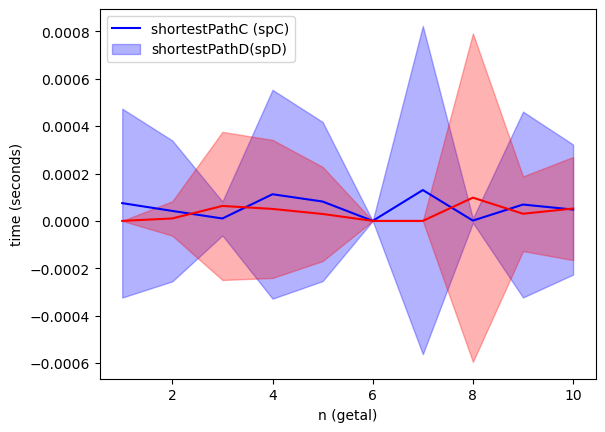

In [37]:
mean_std_max=[]
stdev_std_max=[]
mean_my_max=[]
stdev_my_max=[]
meetpunten = list(range(1,11,1))
for i in meetpunten:
    std =[]
    my = []
    for j in range(50): #vijftig metingen per datapunt
        t1 = time.time()
        spC = shortestPath(gr,v1,v5) #Test 1 
        t2 = time.time()
        std.append(t2-t1)
        t1 = time.time()
        spD = shortestPathD(gr2,1,5)
        t2 = time.time()
        my.append(t2-t1)
    mean_std_max.append(stats.mean(std))
    stdev_std_max.append(stats.stdev(std))
    mean_my_max.append(stats.mean(my))
    stdev_my_max.append(stats.stdev(my))
    
plt.plot(meetpunten, mean_std_max, 'b-')
plt.fill_between(meetpunten, np.array(mean_std_max)-np.array(stdev_std_max), np.array(mean_std_max)+np.array(stdev_std_max), color='b', alpha=0.3)
plt.plot(meetpunten, mean_my_max, 'r-')
plt.fill_between(meetpunten, np.array(mean_my_max)-np.array(stdev_my_max), np.array(mean_my_max)+np.array(stdev_my_max), color='r', alpha=0.3)
plt.xlabel("n (getal)")
plt.ylabel("time (seconds)")
plt.legend(["shortestPathC (spC)", "shortestPathD(spD)"], loc='upper left')
plt.show()


*Schrijf hier de tekst-antwoorden voor Opgave 1*

## Opgave 2: Een andere implentatie?

Verzin (evt. samen met je teamleden) nog een andere manier om grafen te implementeren, en schrijf vervolgens weer een bijbehorende implementatie van Dijkstra's algoritme. Is deze beter dan de vorige twee manieren? Toon dit wederom aan door metingen te doen. 

Ter inspiratie: kijk eens naar **adjacency lists** https://en.wikipedia.org/wiki/Adjacency_list en **adjacency matrices** https://en.wikipedia.org/wiki/Adjacency_matrix . Zou je de edges misschien (evt. per vertex) kunnen sorteren op een manier dat Dijkstra's algoritme makkelijker maakt, en zo ja, is dat computationeel de moeite waard?

In [38]:
#Schrijf hier de code voor opgave 2
gr3 = np.array([
    [None, 7   , 9   , None, None, 14  ],
    [7   , None, 10  , 15  , None, None],
    [9   , 10  , None, 11  , None, 2   ],
    [None, 15  , 11  , None, 6   , None],
    [None, None, None, 6   , None, 9   ],
    [14  , None, 2   , None, 9   , None],
])

def shortestPath_AMGraph(graph, start, finish):
    dist = {}
    prev = {}
    
    for n in range(len(graph)):
        dist[n] = float('inf')
        prev[n] = None
    dist[start] = 0
  
    N = {start}
    S = set()
    while len(N) != 0:
        n = min(N, key=lambda x: dist[x])
        N.remove(n)
        S.add(n)
        
        if n == finish:
            break
        
        for m in range(len(graph)):
            if graph[n][m] is not None:
                if m not in S:
                    if m not in N:
                        N.add(m)

                    altDistance = dist[n] + graph[n][m]
                    if dist[m] > altDistance:
                        dist[m] = altDistance
                        prev[m] = n
                    
    # Reconstruct the shortest path
    path = []
    current_node = finish
    while current_node is not None:
        path.append(current_node)
        current_node = prev[current_node]
    path.reverse()
    
    return dist[finish], path

print(shortestPath_AMGraph(gr3, 0, 4))



(20, [0, 2, 5, 4])


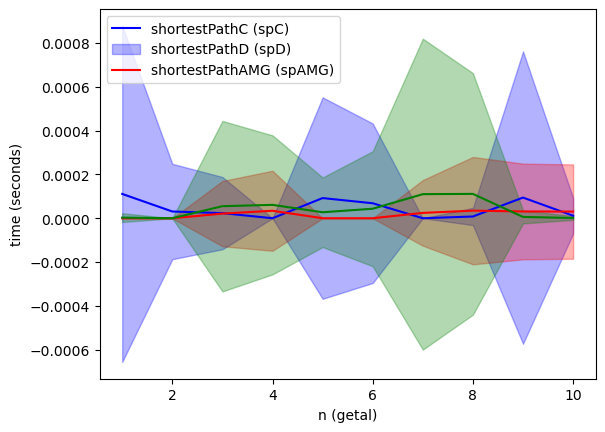

In [39]:
mean_std_max=[]
stdev_std_max=[]
mean_my_max=[]
stdev_my_max=[]
mean_my2_max=[]
stdev_my2_max=[]
meetpunten = list(range(1,11,1))
for i in meetpunten:
    std =[]
    my = []
    my2 =[]
    for j in range(50): #vijftig metingen per datapunt
        t1 = time.time()
        spC = shortestPath(gr,v1,v5) #Test 1 
        t2 = time.time()
        std.append(t2-t1)
        t1 = time.time()
        spD = shortestPathD(gr2,1,5)
        t2 = time.time()
        my.append(t2-t1)
        t1 = time.time()
        spAMG = shortestPath_AMGraph(gr3, 0, 4)
        t2 = time.time()
        my2.append(t2-t1)
    mean_std_max.append(stats.mean(std))
    stdev_std_max.append(stats.stdev(std))
    mean_my_max.append(stats.mean(my))
    stdev_my_max.append(stats.stdev(my))
    mean_my2_max.append(stats.mean(my2))
    stdev_my2_max.append(stats.stdev(my2))
    
plt.plot(meetpunten, mean_std_max, 'b-')
plt.fill_between(meetpunten, np.array(mean_std_max)-np.array(stdev_std_max), np.array(mean_std_max)+np.array(stdev_std_max), color='b', alpha=0.3)
plt.plot(meetpunten, mean_my_max, 'r-')
plt.fill_between(meetpunten, np.array(mean_my_max)-np.array(stdev_my_max), np.array(mean_my_max)+np.array(stdev_my_max), color='r', alpha=0.3)
plt.plot(meetpunten, mean_my2_max, 'g-')
plt.fill_between(meetpunten, np.array(mean_my2_max)-np.array(stdev_my2_max), np.array(mean_my2_max)+np.array(stdev_my2_max), color='g', alpha=0.3)
plt.xlabel("n (getal)")
plt.ylabel("time (seconds)")
plt.legend(["shortestPathC (spC)", "shortestPathD (spD)", "shortestPathAMG (spAMG)"], loc='upper left')
plt.show()


*Schrijf hier de tekst-antwoorden voor Opgave 2*

## Ten Slotte

Grafen kun je dus op heel veel verschillende manieren implementeren. Sommige manieren zijn beter dan anderen voor specifieke algoritmes. Let dus altijd goed op hoe je een graaf implementeert als je aan verschillende toepassingen denkt. 

Ook verschilt de implementatie uiteraard als er wel of geen data in vertices en/of edges moeten worden opgeslagen. 

In het tweede grote practicum, zullen we kijken naar een coordination graph. Dit is een graaf waarbij elke vertex een beslisvariabele voorstelt met een beperkt aantal mogelijke beslissingen (acties / waarden). Elke edge representeert welke lokale beloning je krijgt voor de mogelijke beslissingen voor de beslisvariabelen die dezen verbindt. Kijk bij dit practicum eerst eens goed hoe de graaf geïmplementeerd is. Mocht je daar vragen over hebben stel ze dan z.s.m. aan een van de docenten of aan de studentassistent.   